In [1]:
try:
    import gensim
except:
    !pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 741.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import gensim
from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary


import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

import numpy as np
import pandas as pd

import kagglehub
import multiprocessing

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import defaultdict
import re
import os
import shutil
from time import time

# Setting up the loggings to monitor gensim
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load The data
We use Simpsons data, with more than 150k lines of dialogues.

This dataset contains the characters, locations, episode details, and script lines for approximately 600 Simpsons episodes, dating back to 1989. It can be found here: https://www.kaggle.com/ambarish/fun-in-text-mining-with-simpsons/data

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Load the Simpsons Data with more than 150k lines of dialogues

# Download the dataset from kaggle
path = kagglehub.dataset_download("pierremegret/dialogue-lines-of-the-simpsons")
print("Path to dataset files:", path)

# Locate the downloaded dataset path
print("Files in dataset path:", os.listdir(path))

# Define destination in your Google Drive
destination_path = "/content/simpsons_data"

# Copy the entire folder
shutil.copytree(path, destination_path, dirs_exist_ok=True)
print("Dataset copied to:", destination_path)

100%|██████████| 3.32M/3.32M [00:00<00:00, 123MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pierremegret/dialogue-lines-of-the-simpsons/versions/1
Files in dataset path: ['simpsons_dataset.csv']
Dataset copied to: /content/simpsons_data


In [4]:
file_path = "/content/simpsons_data/simpsons_dataset.csv"
simpsons_df = pd.read_csv(file_path)
simpsons_df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
len(simpsons_df)

158314

In [ ]:
simpsons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158314 entries, 0 to 158313
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   raw_character_text  140500 non-null  object
 1   spoken_words        131855 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [ ]:
simpsons_df.describe()

,raw_character_text,spoken_words
count,140500,131855
unique,6758,121759
top,Homer Simpson,No.
freq,29782,304


In [ ]:
simpsons_df.isnull().sum()

,0
raw_character_text,17814
spoken_words,26459


In [ ]:
# Remove the missing values
simpsons_df = simpsons_df.dropna().reset_index(drop=True)
simpsons_df.isnull().sum()

,0
raw_character_text,0
spoken_words,0


In [ ]:
len(simpsons_df)

131853

### Preprocessing

- Lowercase
- Non-alphabetic characters Removal
- Lemmatization
- Stopwords Removal

In [ ]:
stopwords_nltk = stopwords.words("english")
stop_words = list(set(stopwords_nltk + list(STOP_WORDS)))
stop_words

['meanwhile',
 'hundred',
 '‘re',
 'from',
 'other',
 'onto',
 'made',
 'once',
 '‘d',
 "that'll",
 "they're",
 'if',
 'an',
 "shouldn't",
 'she',
 'about',
 'someone',
 'whenever',
 'before',
 'rather',
 'upon',
 'won',
 "n't",
 "'ve",
 'formerly',
 'two',
 'isn',
 'becomes',
 'beside',
 'go',
 "it'd",
 'others',
 "wasn't",
 'even',
 'so',
 'may',
 'up',
 "we're",
 'less',
 'has',
 'hers',
 'were',
 'toward',
 'against',
 'or',
 'get',
 'else',
 'thence',
 'eight',
 'in',
 'and',
 'many',
 'either',
 'doesn',
 'well',
 'does',
 'i',
 'towards',
 'afterwards',
 'please',
 'front',
 'yourselves',
 'call',
 'a',
 'due',
 'mine',
 'perhaps',
 'across',
 'whoever',
 'without',
 'thereby',
 'again',
 'thereupon',
 'ours',
 'hasn',
 's',
 'show',
 "i've",
 'beyond',
 "we'll",
 "he'll",
 'after',
 'latterly',
 'nowhere',
 'really',
 '‘ve',
 'their',
 'since',
 'seems',
 'hereupon',
 'being',
 '’s',
 'through',
 'yet',
 'unless',
 't',
 'full',
 'bottom',
 'back',
 'don',
 'us',
 'until',
 'ha

In [ ]:
# Lowercase and Remove the non-alphabetic characters
brief_cleaning = (re.sub(pattern="[^A-Za-z']+", repl=" ", string=str(row)).lower() for row in simpsons_df["spoken_words"])

Note: This is generator expression that lazily prepares to clean each row, but it won’t execute until you explicitly iterate over it.

In [ ]:
def cleaning(doc):
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word, if a sentence is only one or two words long, the benefit for the training is very small
    if len(tokens) > 2:
        return " ".join(tokens)

In [ ]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

t = time()
# Speed cleaning using spacy
processed_text = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]  # pipe performs the brief_cleaning and return doc object

print("Time taken for cleaning: {} minutes".format(round((time() - t) / 60, 2)))

Time taken for cleaning: 6.51 minutes


**nlp.pipe()**

The .pipe() method in spaCy is a fast, efficient way to process a large amount of text. It allows to
- stream documents instead of loading them all at once (lower memory usage),
- batch-process them under the hood (faster due to optimized execution and parallelization),
- and optionally parallelize using multiple threads or processes.

**batch_size=5000**

This means spaCy will process the texts in chunks of 5000 at a time before moving to the next batch. For example, if you had 150,000 rows, it processes 5000 at once, then the next 5000, and so on...This improves speed and memory efficiency.

What we are doing below is, we are passing a generator of texts (in this case, brief_cleaning) to spaCy, and spaCy processes them in batches of 5000 texts at a time.

**What happens inside nlp.pipe()?**
spaCy does not return all 5000 Doc objects at once. Instead, it yields one Doc object at a time from the batch. Internally, spaCy processes 5000 texts at once (for speed), but you consume the results one-by-one (in your loop or list comprehension).

In [ ]:
# Drop duplicates and na
df_clean = pd.DataFrame({"clean": processed_text})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85952, 1)

In [ ]:
# Generate Bigrams and Trigrams using Spacy Phrases and Phraser
sentences = [row.split() for row in df_clean["clean"]]
bigram_phrases_mdl = Phrases(sentences=sentences, min_count=30, progress_per=10000)  # setences = list[list[tokens]]

bigrams = Phraser(bigram_phrases_mdl)

# trigram_phrases_mdl = Phrases(sentences=bigram_phrases_mdl[sentences])
# trigrams = Phraser(trigram_phrases_mdl)

# def generate_bigrams(sentences):
#     bigrams_data = [bigrams[sent] for sent in sentences]
#     return bigrams_data

# def generate_trigrams(sentences):
#     trigrams_data = [trigrams[bigrams[sent]] for sent in sentences]
#     return trigrams_data

# bigram_data = generate_bigrams(sentences)
# data_bigram_trigram = generate_trigrams(bigram_data)

bigram_data = bigrams[sentences]

In [ ]:
# len(data_bigram_trigram)

113182

In [ ]:
len(bigram_data)

85952

In [ ]:
# Sanity check for frequent words
word_freq = defaultdict(int)
for sent in sentences:
    for word in sent:
        word_freq[word] += 1
len(word_freq)

29572

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'go', 'get', 'know', 'hey', "'", 'think', 'come', 'right']

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

- min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
- window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
- vector_size = int - Dimensionality of the feature vectors. - (50, 300)
- sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
- alpha = float - The initial learning rate - (0.01, 0.05)
- min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
- negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
- workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [ ]:
model = Word2Vec(sg=1, window=2, negative=20, vector_size=300, min_count=20, sample=6e-5, alpha=0.03, min_alpha=0.0007, workers=cores-1) # Skipgram with negative smapling

In [ ]:
# build vocab
t = time()
model.build_vocab(bigram_data, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [ ]:
# Train
t = time()
model.train(bigram_data, total_examples=model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.35 mins


### Precompute L2-normalized vectors

As we do not plan to train the model any further, we are calling `init_sims()`, which will make the model much more memory-efficient.

If replace is set, forget the original vectors and only keep the normalized ones = saves lots of memory!

Note that you cannot continue training after doing a replace. The model becomes effectively read-only = you can call most_similar, similarity etc., but not train.

DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions.
  `model.init_sims(replace=True)`
WARNING:gensim.models.keyedvectors:destructive init_sims(replace=True) deprecated & no longer required for space-efficiency

In [ ]:
# model.init_sims(replace=True)

### Exploring the model

**Most similar to:**
Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

Let's see what we get for the show's main character:

In [ ]:
model.wv.most_similar(positive=["homer"])

[('marge', 0.6200150847434998),
 ('moe', 0.5363897085189819),
 ('mom', 0.5282701849937439),
 ('know', 0.5094074010848999),
 ('convince', 0.5094014406204224),
 ('hey', 0.5084822177886963),
 ('sweetheart', 0.5080437064170837),
 ('homie', 0.5068261623382568),
 ('hammock', 0.5048686861991882),
 ('brad', 0.5037117004394531)]

The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do not necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

Let's see what the bigram "homer_simpson" gives us by comparison:

In [ ]:
model.wv.most_similar(positive=["homer_simpson"])

[('sector', 0.5293119549751282),
 ('recent', 0.5244616866111755),
 ('versus', 0.5201917290687561),
 ('easily', 0.4935474395751953),
 ('pleased', 0.4803231656551361),
 ('pledge', 0.46737661957740784),
 ('mr_burns', 0.4622058570384979),
 ('sir', 0.45623502135276794),
 ('aboard', 0.4552532136440277),
 ('gumbel', 0.4548300504684448)]

what about marge now

In [ ]:
model.wv.most_similar(positive=["marge"])

[('homer', 0.6200150847434998),
 ('flanders', 0.5371452569961548),
 ('husband', 0.5122402906417847),
 ('mom', 0.5094221830368042),
 ('wife', 0.5072061419487),
 ('awww', 0.5051608681678772),
 ('son', 0.4993779957294464),
 ('affair', 0.4952031373977661),
 ('anyhoo', 0.49480777978897095),
 ('honey', 0.48966488242149353)]

In [ ]:
# Lets check Bart now
model.wv.most_similar(positive=["bart"])

[('lisa', 0.705143928527832),
 ('strangle', 0.6078553795814514),
 ('kid', 0.5968140363693237),
 ('dad', 0.5958001017570496),
 ('hearing', 0.5867279767990112),
 ('mom_dad', 0.5612038373947144),
 ('maggie', 0.5607935190200806),
 ('homework', 0.5605937838554382),
 ('mom', 0.5584970712661743),
 ('boy', 0.5521607995033264)]

### Similarities:
Here, we will see how similar are two words to each other :

In [ ]:
model.wv.similarity("moe", 'tavern')

0.67116004

Who could forget Moe's tavern? Not Barney.

In [ ]:
model.wv.similarity('maggie', 'baby')

0.49154297

Maggie is indeed the most renown baby in the Simpsons!

In [ ]:
model.wv.similarity('bart', 'nelson')

0.41357246

Bart and Nelson, though friends, are not that close, makes sense!

### Odd-One-Out:
Here, we ask our model to give us the word that does not belong to the list!

Between Jimbo, Milhouse, and Kearney, who is the one who is not a bully?

In [ ]:
model.wv.doesnt_match(["jimbo", "milhouse", "kearney"])

'jimbo'

Milhouse of course!

What if we compared the friendship between Nelson, Bart, and Milhouse?

In [ ]:
model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

Seems like Nelson is the odd one here!

Last but not least, how is the relationship between Homer and his two sister-in-laws?

In [ ]:
model.wv.doesnt_match(["homer", "patty", "selma"])

'homer'

Damn, they really do not like you Homer!

### Analogy difference:
Which word is to woman as homer is to marge?

In [ ]:
model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('man', 0.4252314567565918),
 ('admire', 0.4134786128997803),
 ('apparently', 0.40646666288375854)]

"man" comes at the first position, that looks about right!

Which word is to woman as bart is to man?

In [ ]:
model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('hearing', 0.4934554100036621),
 ('lisa', 0.48521167039871216),
 ('anyhoo', 0.45167139172554016)]

Lisa is Bart's sister, her male counterpart!

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in **red**), its most similar words in the model (in **blue**), and other words from the vocabulary (in **green**).

In [ ]:
model.vector_size

300

In [ ]:
model.wv.__getitem__(["homer"]).shape

(1, 300)

In [ ]:
def tsnescatterplot(model, word, list_names):
    """
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.

    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 19 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    # TSNE
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    # Figure
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", scatter_kws={'s': 40, 'facecolors': df['color']})

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line], df['y'][line], '  ' + df["words"][line].title(),
                 horizontalalignment='left', verticalalignment='bottom', size='medium', color=df['color'][line], weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

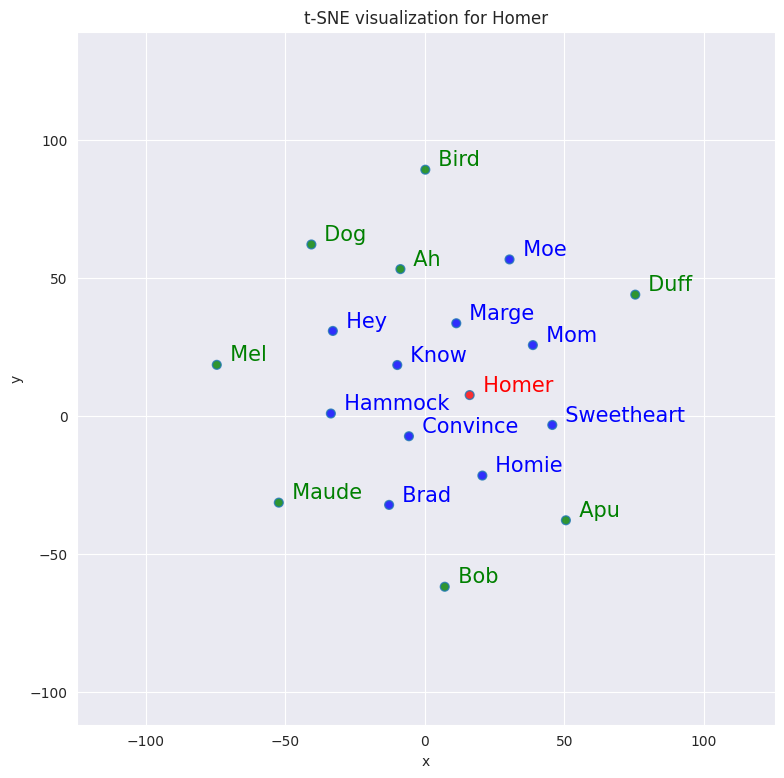

In [ ]:
tsnescatterplot(model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

Interestingly, the 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

### 10 Most similar words vs. 10 Most dissimilar
This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie

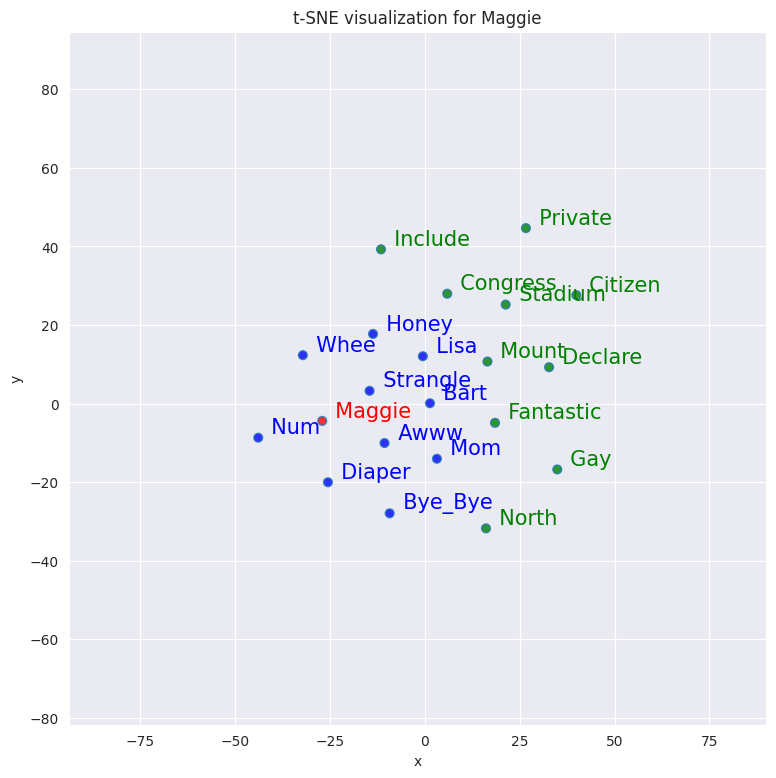

In [ ]:
tsnescatterplot(model, 'maggie', [i[0] for i in model.wv.most_similar(negative=["maggie"])])

Neat! Maggie and her most similar words form a distinctive cluster from the most dissimilar words, it is a really encouraging plot!

### 10 Most similar words vs. 11th to 20th Most similar words:
Finally, we are going to plot the most similar words to Mr. Burns ranked 1st to 10th versus the ones ranked 11th to 20th:

(PS: Mr. Burns became mr_burn after the preprocessing)

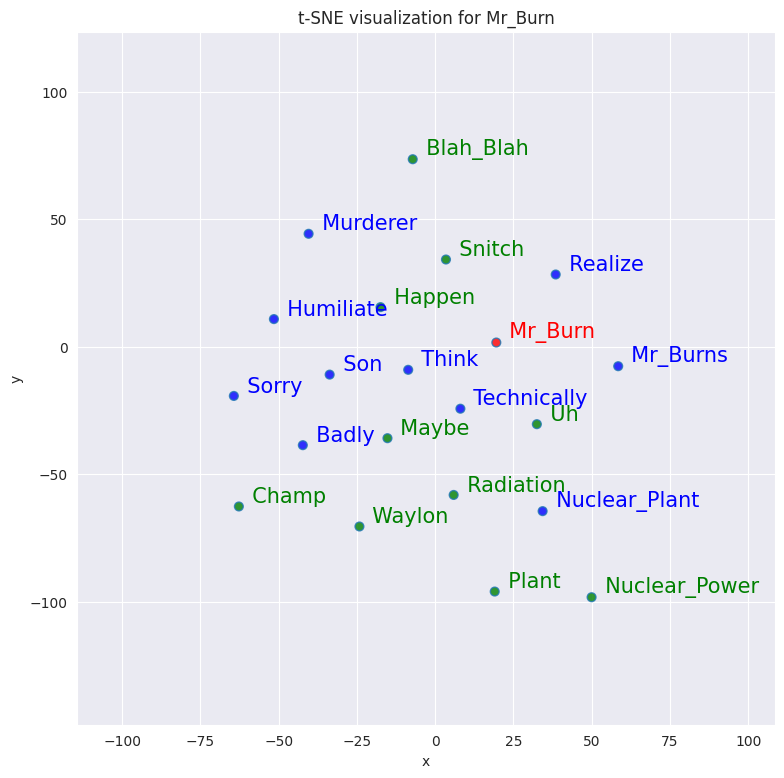

In [ ]:
tsnescatterplot(model, "mr_burn", [t[0] for t in model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])

As we can see, and that is very nice, all the 20 words are forming one cluster around Mr. Burns.

In [5]:
# Self Practice
import gensim
from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import spacy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

t = time()
df = pd.read_csv("/content/simpsons_data/simpsons_dataset.csv")
df = df.dropna().reset_index(drop=True)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

alpha_cleaning = (re.sub("[^A-Za-z']+", " ", str(row)).lower() for row in df["spoken_words"])

def preprocess_doc(doc):
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    if len(tokens) > 2:
        return " ".join(tokens)

clean_text = [preprocess_doc(doc) for doc in nlp.pipe(alpha_cleaning, batch_size=5000, n_process=-1)]

df_clean = pd.DataFrame({"clean": clean_text})
df_clean = df_clean.dropna().drop_duplicates()
final_text = [row.split() for row in df_clean["clean"]]

phrases_mdl = Phrases(sentences=final_text, min_count=20, progress_per=10000)
bigram = Phraser(phrases_mdl)
bigram_data = bigram[final_text]

model = Word2Vec(sg=0, negative=20, window=2, vector_size=300, min_count=20, sample=6e-5, alpha=0.03, min_alpha=0.0007, workers=-1)
model.build_vocab(bigram_data, progress_per=10000)
model.train(bigram_data, total_examples=model.corpus_count, epochs=30, report_delay=1)

print(model.wv.most_similar(["homer"]))
print(model.wv.most_similar(["marge"]))
print(model.wv.doesnt_match(["homer", "marge", "bart"]))
print(model.wv.doesnt_match(["homer", "patty", "selma"]))
print(model.wv.similarity("moe", "tavern"))
print(model.wv.similarity("maggie", "baby"))
print(model.wv.most_similar(positive=["homer", "woman"], negative=["marge"], topn=3))
print(model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3))

[('grampa', 0.22942174971103668), ('relate', 0.212319478392601), ('ski', 0.21028056740760803), ('totally', 0.18356697261333466), ('send', 0.1776614636182785), ('earn', 0.16962334513664246), ('metal', 0.16937148571014404), ('drunken', 0.16934461891651154), ('uhh', 0.16798816621303558), ('book', 0.16553591191768646)]
[('go_to', 0.2100597470998764), ('admire', 0.18724371492862701), ('mansion', 0.17908182740211487), ('musk', 0.17255547642707825), ('freedom', 0.16293711960315704), ('wise', 0.16108670830726624), ('talk', 0.15745866298675537), ('hair', 0.15645016729831696), ('friend', 0.15627439320087433), ('barn', 0.1561310589313507)]
marge
selma
-0.011134109
0.07335726
[('cone', 0.20941336452960968), ('cloud', 0.2027246057987213), ('wipe', 0.1807587593793869)]
[('select', 0.19451236724853516), ('estate', 0.18657168745994568), ('weekend', 0.17558693885803223)]
